In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yfin
import utils as erk 
import FactorModelLibForMOOC as fm 


%load_ext autoreload
%autoreload 2

In [3]:
tickers = ['d05.si', 'cc3.si', 'u11.si', 'ov8.si', 'z74.si', 'bn4.si', 'c6l.si', 'o39.si', 'g13.si', 's68.si']

dataframe = yfin.download(tickers, period = '20y')['Adj Close']
returns = dataframe.pct_change().dropna()

mreturns = returns.resample('M').apply(erk.compound).to_period('M')

mreturns 


[*********************100%%**********************]  9 of 10 completed

10 Failed downloads:
['OV8.SI', 'S68.SI', 'O39.SI', 'Z74.SI', 'CC3.SI', 'D05.SI', 'BN4.SI', 'C6L.SI', 'G13.SI', 'U11.SI']: YFInvalidPeriodError("%ticker%: Period '20y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']")


Unexpected exception formatting exception. Falling back to standard exception


C:\Users\Admin\AppData\Local\Temp\ipykernel_35656\2624028218.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mreturns = returns.resample('M').apply(erk.compound).to_period('M')
Traceback (most recent call last):
  File "c:\Users\Admin\PycharmProjects\Portfolio Analysis\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    elif mode == "single":
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_35656\2624028218.py", line 6, in <module>
    mreturns = returns.resample('M').apply(erk.compound).to_period('M')
  File "c:\Users\Admin\PycharmProjects\Portfolio Analysis\.venv\lib\site-packages\pandas\core\frame.py", line 12367, in to_period
    raise TypeError(f"unsupported Type {type(old_ax).__name__}")
TypeError: unsupported Type MultiIndex

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Admin\PycharmProjects\Portfolio Analysis

##Idea 

Since weight_cw returns a specific weighting scheme at a specific date, can we we compute a time series of cap weights assuming we rebalance it every month/quater/year?
Similarly, can we compute a time series of msr weights at each specified time period in history, then we can do a back test of the total 
Again, calculate a 1 year gmv, then 1.25 year gmv, and so on, with increment of 0.25 year. 

In [6]:
ewr = erk.backtest_ws(mreturns, estimation_window=60, weighting=erk.weight_ew)
#cwr = erk.backtest_ws(returns, estimation_window=60, weighting=erk.weight_cw, cap_weights=ind_mcap)
mv_sr = erk.backtest_ws(mreturns, estimation_window = 60, weighting= erk.weight_gmv, cov= erk.sample_cov)
mv_cc_r = erk.backtest_ws(mreturns, estimation_window=60, weighting=erk.weight_gmv, cov_estimator=erk.cc_cov)
mv_sh_r = erk.backtest_ws(mreturns, estimation_window=60, weighting=erk.weight_gmv, cov_estimator=erk.shrinkage_cov, delta=0.5)
msr = erk.msr_window_annrets(mreturns, estimation_window=60)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.078783,0.135590,0.127732,6.243871,0.052978,0.072269,0.350012,-0.227434
GMV-Sample,0.031529,0.122049,-0.307667,6.122128,0.055235,0.075965,0.012039,-0.191900
GMV-CC,0.053654,0.127054,-0.098069,5.942100,0.053827,0.076861,0.181040,-0.198344
GMV-Shrink 0.5,0.040690,0.122098,-0.201769,5.981971,0.053600,0.073981,0.085064,-0.193401
MSR,0.085462,0.139983,1.662034,11.855719,0.030230,0.068302,0.385471,-0.128043


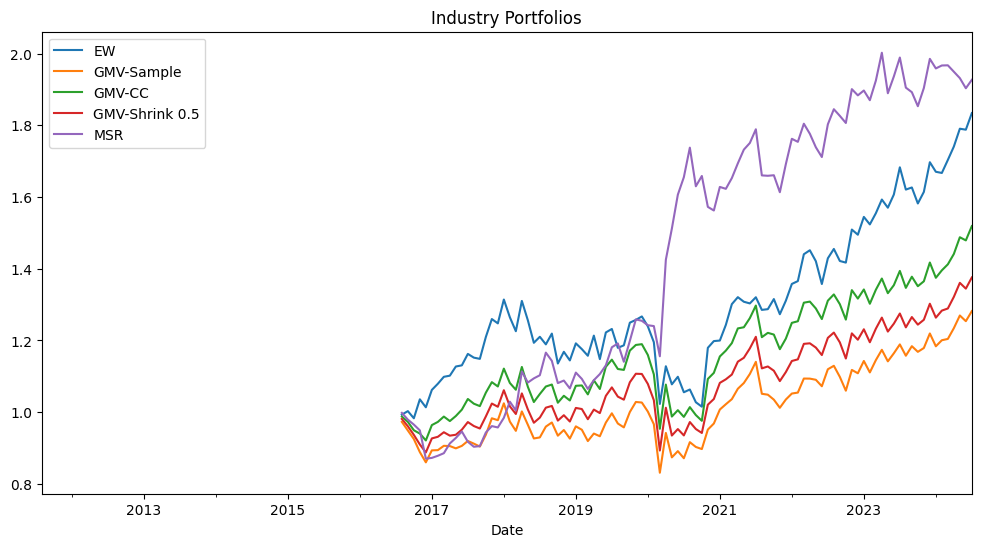

In [7]:
btr = pd.DataFrame({"EW": ewr, "GMV-Sample": mv_sr, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r, 'MSR' : msr[0]})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

In [20]:
weights = erk.msr_window_annrets(mreturns, estimation_window=60)[1]

In [24]:
value  = erk.value(sum = 10000, weights= weights)

In [8]:
erk.num(value = value, tickerlist=tickers)

c:\Users\Admin\PycharmProjects\First-Workshop\edhec_risk_kit_206.py:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
c:\Users\Admin\PycharmProjects\First-Workshop\edhec_risk_kit_206.py:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
c:\Users\Admin\PycharmProjects\First-Workshop\edhec_risk_kit_206.py:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


NameError: name 'value' is not defined

## Estimating Covariance with BETAS 

im not sure if this is covered, need to check this out, 
but if we can use Fama French models to estimate covariance with betas 
this works together with the idea above as BETAs for each stock would be calculated 
